In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from sklearn.metrics import confusion_matrix, roc_curve### metrics
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau


Data Preparation


**Data Loading**





In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [3]:
print(len(dataset[0]))

27558


In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1

In [6]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )


In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2757


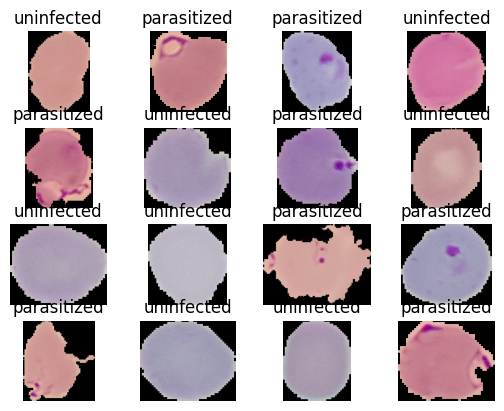

In [8]:
for i ,(image , label ) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


**Data Preprocessing**


In [9]:
IM_SIZE = 224



def resize_rescale(image , label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0, label


train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)



In [10]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
BATCH_SIZE = 32


train_dataset = (train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))


In [12]:
# I have imported the saved model

saved_model = tf.keras.models.load_model('my_model.keras')
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

**Sequential API**

In [13]:
# IM_SIZE = CONFIGURATION['IM_SIZE']
# DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
# REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
# N_FILTERS = CONFIGURATION['N_FILTERS']
# KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
# POOL_SIZE = CONFIGURATION['POOL_SIZE']
# N_STRIDES = CONFIGURATION['N_STRIDES']


lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),


    Conv2D(filters =16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( 100, activation = "relu"),
    BatchNormalization(),


    Dense( 10, activation = "relu", ),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [47]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [14]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

In [33]:
#I have all the daat saved in my saved model now  I can just import that and it will run


history=saved_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
 73/689 [==>...........................] - ETA: 30s - loss: 0.0562 - accuracy: 0.9807

KeyboardInterrupt: 

**FUNCTIONAL API**

In [15]:
func_input=Input(shape=(IM_SIZE,IM_SIZE,3) ,  name ="Input Image")

x=Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D (pool_size = 2, strides= 2)(x)

x=Conv2D(filters =16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu')(x)

x=BatchNormalization()(x)
output=MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor=Model(func_input,output,name="Feature_Extractor")
feature_extractor.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

In [16]:


feature_extractor_seq_model=tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Conv2D(filters =16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

as we can see both have the same parameters


In [17]:
x=feature_extractor(func_input)
x=Flatten()(x)

x=Dense( 100, activation = "relu")(x)
x=BatchNormalization()(x)

x=Dense( 10, activation = "relu")(x)
x=BatchNormalization()(x)

func_output=Dense(1, activation = "sigmoid")(x)

func_model=Model(func_input,func_output,name="Functional_Model")
func_model.summary()

Model: "Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)           

As we can see both the models have same parameters but in functional api we have all feature extractor as a function

**MODEL SUBCLASSING**


In [18]:
class FeatureExtractor(Layer):
  def __init__(self, filters ,kernel_size, strides, padding,activation,pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv1=Conv2D(filters = filters , kernel_size =kernel_size, strides = strides , padding=padding,
          activation = activation)
    self.batch1=BatchNormalization()
    self.pool1=MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv2=Conv2D(filters =filters*2 , kernel_size =kernel_size, strides = strides , padding=padding,
          activation = activation)
    self.batch2=BatchNormalization()
    self.pool2=MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self,x):
    x=self.conv1(x)
    x=self.batch1(x)
    x=self.pool1(x)

    x=self.conv2(x)
    x=self.batch2(x)
    x=self.pool2(x)

    return x

feature_sub_classed=FeatureExtractor(8,3,1,"valid","relu",2)

In [19]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func_subclass = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func_subclass.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

In [20]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Bat  multiple                 

**CUSTOM LAYERS**

In [21]:
class custom_layers(Layer):
    def __init__(self,output_units,activation):
        super(custom_layers,self).__init__()
        self.output_units=output_units
        self.activation=activation

    def build(self,input_features_shape):
        self.w=self.add_weight(shape=(input_features_shape[-1],self.output_units),initializer = "random_normal", trainable = True)
        self.b=self.add_weight(shape=(self.output_units,),initializer="random_normal",trainable=True)

    def call(self,input_features):
        pre_output=tf.matmul(input_features,self.w)+self.b

        if(self.activation=="relu"):
            return tf.nn.relu(pre_output)

        elif(self.activation=="sigmoid"):
            return tf.math.sigmoid(pre_output)

        else:
            return pre_output

In [22]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),
                             
                             custom_layers(100, activation = "relu"),
                             BatchNormalization(),
                             
                             custom_layers(10, activation = "relu"),
                             BatchNormalization(),

                             custom_layers(1, activation = "sigmoid"),

])
lenet_custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [48]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.01),
                          loss=BinaryCrossentropy(),
                          metrics=metrics)

In [28]:
lenet_custom_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5
689/689 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8610

KeyboardInterrupt: 

In [36]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


**CALLBACKS**

In [29]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
    
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

**CSVLogger**

In [33]:
#to save the checkpoints in a csv data file 

csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)


**EarlyStopping**

In [42]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)


**LearningRateScheduler**

In [56]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

**ModelCheckpointing**

In [61]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

**ReduceLearningRateOnPlateau**

In [62]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

**TRAINING FOR CALLBACKS**

In [38]:
lenet_custom_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1,callbacks=[LossCallback(),])

Epoch 1/5

 For Batch Number 1 the model has a loss of {'loss': 0.016149241477251053, 'accuracy': 1.0} 
  1/689 [..............................] - ETA: 3:30 - loss: 0.0161 - accuracy: 1.0000
 For Batch Number 2 the model has a loss of {'loss': 0.12775544822216034, 'accuracy': 0.953125} 

 For Batch Number 3 the model has a loss of {'loss': 0.12056803703308105, 'accuracy': 0.9583333134651184} 
  3/689 [..............................] - ETA: 32s - loss: 0.1206 - accuracy: 0.9583 
 For Batch Number 4 the model has a loss of {'loss': 0.1512841284275055, 'accuracy': 0.953125} 
  4/689 [..............................] - ETA: 32s - loss: 0.1513 - accuracy: 0.9531
 For Batch Number 5 the model has a loss of {'loss': 0.1709308922290802, 'accuracy': 0.9437500238418579} 

 For Batch Number 6 the model has a loss of {'loss': 0.15874464809894562, 'accuracy': 0.9479166865348816} 
  6/689 [..............................] - ETA: 33s - loss: 0.1587 - accuracy: 0.9479WARNING:tensorflow:Callback method `


 For Batch Number 7 the model has a loss of {'loss': 0.14207172393798828, 'accuracy': 0.9553571343421936} 
  7/689 [..............................] - ETA: 33s - loss: 0.1421 - accuracy: 0.9554
 For Batch Number 8 the model has a loss of {'loss': 0.13750885426998138, 'accuracy': 0.953125} 

 For Batch Number 9 the model has a loss of {'loss': 0.13737188279628754, 'accuracy': 0.9513888955116272} 
  9/689 [..............................] - ETA: 33s - loss: 0.1374 - accuracy: 0.9514
 For Batch Number 10 the model has a loss of {'loss': 0.15574462711811066, 'accuracy': 0.9437500238418579} 
 10/689 [..............................] - ETA: 33s - loss: 0.1557 - accuracy: 0.9438
 For Batch Number 11 the model has a loss of {'loss': 0.150726780295372, 'accuracy': 0.9488636255264282} 

 For Batch Number 12 the model has a loss of {'loss': 0.1426175981760025, 'accuracy': 0.953125} 
 12/689 [..............................] - ETA: 33s - loss: 0.1426 - accuracy: 0.9531
 For Batch Number 13 the model 

KeyboardInterrupt: 

In [51]:
history=lenet_custom_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[csv_callback,es_callback])

Epoch 1/10
689/689 [==============================] - 28s 40ms/step - loss: 0.0769 - tp: 10820.0000 - fp: 366.0000 - tn: 10655.0000 - fn: 205.0000 - accuracy: 0.9741 - precision: 0.9673 - recall: 0.9814 - auc: 0.9953 - val_loss: 0.4429 - val_tp: 832.0000 - val_fp: 54.0000 - val_tn: 1306.0000 - val_fn: 563.0000 - val_accuracy: 0.7760 - val_precision: 0.9391 - val_recall: 0.5964 - val_auc: 0.9587
Epoch 2/10
689/689 [==============================] - 26s 37ms/step - loss: 0.0654 - tp: 10829.0000 - fp: 317.0000 - tn: 10706.0000 - fn: 194.0000 - accuracy: 0.9768 - precision: 0.9716 - recall: 0.9824 - auc: 0.9964 - val_loss: 0.1756 - val_tp: 1331.0000 - val_fp: 74.0000 - val_tn: 1289.0000 - val_fn: 61.0000 - val_accuracy: 0.9510 - val_precision: 0.9473 - val_recall: 0.9562 - val_auc: 0.9788
Epoch 3/10
689/689 [==============================] - 34s 49ms/step - loss: 0.0554 - tp: 10869.0000 - fp: 263.0000 - tn: 10760.0000 - fn: 154.0000 - accuracy: 0.9811 - precision: 0.9764 - recall: 0.9860 -

**Visualizations**

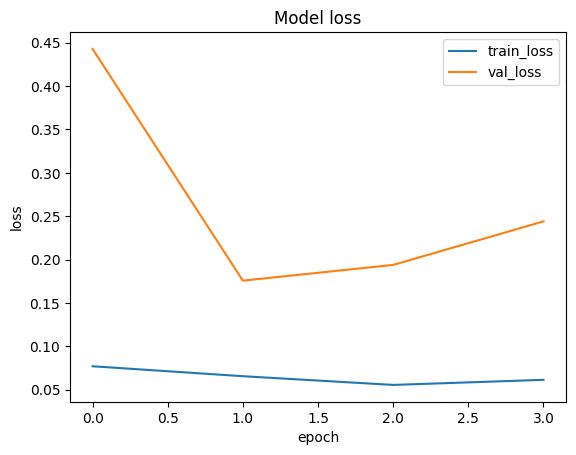

In [52]:




plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

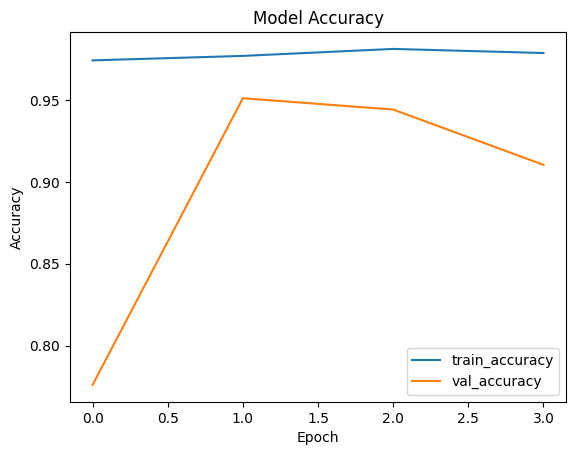

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**Model Evaluation and Testing**

In [41]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [42]:
test_dataset = test_dataset.batch(1)

saved_model.evaluate(test_dataset)

2757/2757 [==============================] - 7s 2ms/step - loss: 0.2442 - accuracy: 0.9180


[0.24417783319950104, 0.918026864528656]